In [1]:
%matplotlib notebook
import logging
from typing import List

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("my_official")
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, FloatSlider, RadioButtons, Layout, widgets
import ipywidgets as widgets
from matplotlib import cm
from scipy import integrate
from pyprind import ProgBar

from qubit.utils.quantum_constants import QuantumConstants

TWO_PI = 2 * np.pi
Q_0 = QuantumConstants.eCharge * 2

# CQPS simulation
- All voltages normalised by $Q_0=2e$
- Time will be in units of ns (and correspondigly GHz)

The numerical simulation will begin with initial, $i=0$, $n_cqps=0$, and use derivatives to compute next value:

\begin{equation}
 \begin{aligned}
   \color{red}{\dot{i}} & = \frac{V_b}{LQ_0} + \frac{V_{mw}}{LQ_0}\cos{\left( 2\pi f_{mw} \color{red}{t}\right)} - \frac{R}{L}\color{red}{i} + \frac{V_{s}}{LQ_0}\sin{\left( 2\pi\color{red}{n_{\text{cqps}}} \right)}\\
   \color{red}{\dot{n}_{\text{cqps}}} & = \frac{1}{1 + \frac{2\pi{C}V_{s}}{Q_{0}}\cos{\left( 2\pi\color{red}{n_{\text{cqps}}} \right)}} \color{red}{i}
 \end{aligned}
\end{equation}

<IPython.core.display.Javascript object>


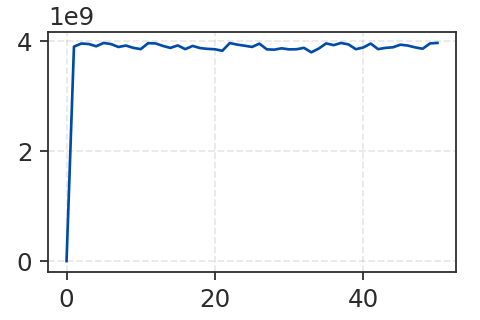

In [2]:
uV = 10**(-6)
GHz = 1
ns = 1
uH = 10**(-6)
fF = 10**(-15)

def slimmed_kernel(t: float, state_vector: List[float],
                   V_b_over_L: float, V_mw_over_L: float, omega_mw: float,
                   V_s: float, R_over_L: float, L: float, C: float,
    ) -> List[float]:
    """Requires even more pre-computed parameters"""
    
    (i, ncqps) = state_vector
    di_dt = (
        V_b_over_L
        + (V_mw_over_L * np.cos(omega_mw * t))
        - i * R_over_L
        - V_s / L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / (
        1 + TWO_PI * C * V_s * np.cos(TWO_PI * ncqps)
    )
    return [di_dt, dncqps_dt]


def kernel(t: float, state_vector: List[float],
           V_b: float, V_mw: float, f_mw: float,
           V_s: float, R: float, L: float, C: float) -> List[float]:
    (i, ncqps) = state_vector
    di_dt = (
        (V_b / L)
        + (V_mw / L * np.cos(TWO_PI * f_mw * t))
        - R * i / L
        - V_s / L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / (
        1 + TWO_PI * C * V_s * np.cos(TWO_PI * ncqps)
    )
    return [di_dt, dncqps_dt]


V_b = 20*uV
V_mw = 5*uV
f_mw = 2*GHz
V_s = 5*uV
R = 20_000
L = 10*uH
C = 1*fF

t_list = np.linspace(0, 0.001, 51)
state_initial = [0, 0]
progress_bar = ProgBar(100, bar_char="█")
simulation = integrate.solve_ivp(
    fun=slimmed_kernel,
    t_span=(0, max(t_list)),
    y0=state_initial,
    t_eval=t_list,
    args=(V_b / L / Q_0, V_mw / L / Q_0, f_mw * TWO_PI, V_s / Q_0, R / L, L, C),
    method="RK45",
)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t_list, simulation["y"][0])
ax.set_xlabel("Time, t (ns)", fontsize=12)
ax.set_ylabel("Current, I (A)", fontsize=12)

In [19]:
%%time

V_b = 20*uV
V_mw = 5*uV
f_mw = 2*GHz
V_s = 5*uV
R = 20_000
L = 10*uH
C = 1*fF

t_list = np.linspace(0, 0.0001, 21)
state_initial = [1, 0]
simulation = integrate.solve_ivp(
    fun=slimmed_kernel, 
    t_span=(0, max(t_list)),
    y0=state_initial,
    t_eval=t_list,
    args=(V_b / L / Q_0, V_mw / L / Q_0, f_mw * TWO_PI, V_s / Q_0, R / L, L, C),
    method="RK45",
)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t_list, simulation["y"][0])
ax.set_xlabel("Time, t (ns)", fontsize=12)
ax.set_ylabel("Current, I (A)", fontsize=12)

plt.show()

## Bessel Functions

<IPython.core.display.Javascript object>


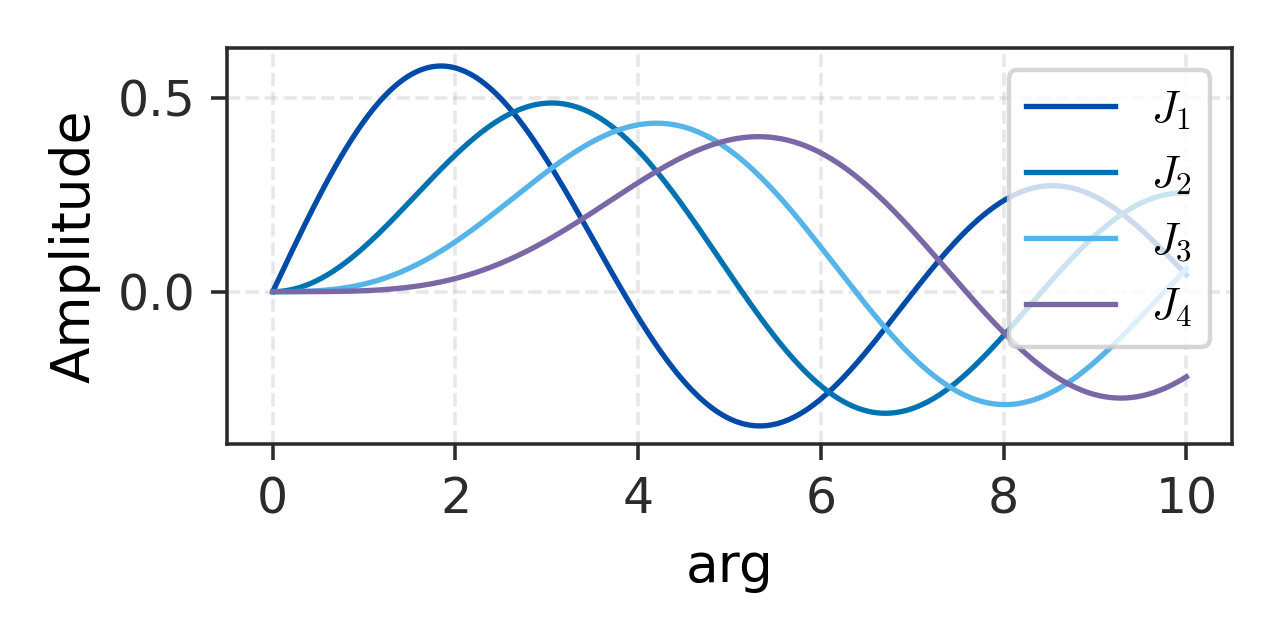

In [82]:
t_list = np.linspace(0,10,500)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
for i in range(1, 5):
    ax.plot(t_list, spl.jv(i, t_list), label=f"$J_{i}$")
ax.set_xlabel("arg", fontsize=12)
ax.set_ylabel("Amplitude", fontsize=12)
plt.tight_layout()
def update(bessel_selection):
    plt.cla()
    for i in range(bessel_selection[0] + 1, bessel_selection[1]):
        ax.plot(t_list, spl.jv(i, t_list), label=f"$J_{i}$")
ax.legend()
plt.savefig("output/bessel_plot.png")

bessel_selection_widget = widgets.IntRangeSlider(
    value=[0, 1],
    min=0,
    max=10,
    step=1,
    description='Bessel selection',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=Layout(width='90%'),
)
ui = widgets.VBox([bessel_selection_widget])

In [79]:
out = widgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "bessel_selection": bessel_selection_widget,
    }
)

display(ui, out)


Output()

In [56]:
um = 10**(-6)

In [57]:
Vc = 5*um
L = 10**(-6)
# Kinetic capacitance


# Simulating a JJ
\begin{equation}
  \begin{aligned}
    I(t) & = \color{\green}{\frac{d}{dt}\left[ CV \right]} + \color{blue}{\frac{V}{R}} + \color{red}{\text{JJ current}}\\
    & = \color{green}{C}\frac{d^2\Phi}{dt^{2}} + \color{blue}{\frac{1}{R}}\frac{d\Phi}{dt} + \color{red}{I_c}\sin{\left[ 2\pi \frac{\Phi}{\Phi_{0}} \right]}
  \end{aligned}
\end{equation}

In [1]:
# Lets plot this as a function of time

Ic = 1
C = 

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

h = 6.64 * 10 ** (-34)
eCharge = 1.6 * 10 ** (-19)
Phi0 = h / (2 * eCharge)
kb = 1.38 * 10 ** (-23)
phi0_2pi = Phi0 / 2 * np.pi

# Just biasing by a constant current

\begin{equation}
 I = \frac{1}{R}\frac{\Phi_0}{2\pi}\frac{d\phi}{dt} + I_c\sin(\varphi)
\end{equation}

In [29]:
def model_v1(phi, t, I, Ic, R_scaled):
    # Params: (I, I_c, R*2pi/Phi0)
#     I = 0
#     Ic = 1
#     R_scaled = 1
    return (I - Ic * np.sin(phi)) * R_scaled

phi_init = 0
t_list = np.linspace(0, 20)

<IPython.core.display.Javascript object>


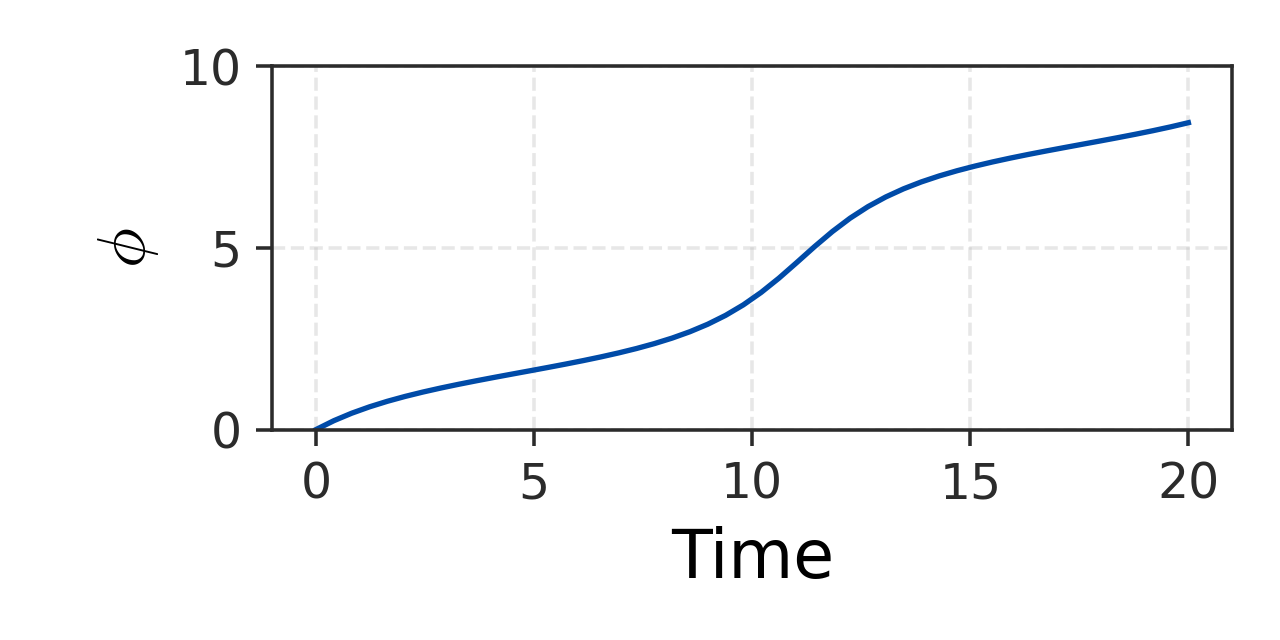

In [54]:
# Initial simulation
I = 0.5
Ic = 0.5
R_scaled = 2
phi_list = odeint(model, phi_init, t_list, args=(I, Ic, R_scaled))

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
graph, = ax.plot(t_list, phi_list)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("$\phi$", fontsize=15)
ax.set_ylim([0, 10])
plt.tight_layout()

# Interactive plot
def update(I: float, Ic: float, R_scaled: float):
    phi_list = odeint(model, phi_init, t_list, args=(I, Ic, R_scaled))
    graph.set_ydata(phi_list)

I_widget = FloatSlider(
    min=0, max=1, step=0.01,
    description="Bias current, I", value=I,
    layout=Layout(width='90%'),
    continuous_update=True
)
Ic_widget = FloatSlider(
    min=0, max=1, step=0.01,
    description="Critical current, Ic", value=Ic,
    layout=Layout(width='90%'),
    continuous_update=True
)
R_widget = FloatSlider(
    min=0, max=2,
    description="Resistance, R", value=R_scaled,
    layout=Layout(width='90%'),
    continuous_update=True
)
ui = widgets.VBox([I_widget, Ic_widget, R_widget])

In [55]:
out = widgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "I": I_widget,
        "Ic": Ic_widget,
        "R_scaled": R_widget}
)

display(ui, out)

Output()

## Investigating what happens to voltage